# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [165]:
## TODO
# Hyperparameter tuning:
# 1. How many uncorrelated pairs do we want
# 2. Epochs
# 3. Batch size
# 4. Number of layers, number of nodes per layer
# 5. Activation functions

In [166]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix

### 1. Import Vectors and Pre-Process them

In [167]:
# Import vec file
with open('AllVectorResults.lst', 'r') as file:
    text = file.read()

In [168]:
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [169]:
df.head()

,ID,Vector
0,MESH:D012559,"[0.01491615, -0.00155747, -0.30986652, 0.04035..."
1,MESH:D009404,"[3.82804424e-02, 1.29408345e-01, 3.75053808e-0..."
2,MESH:D001749,"[-0.01025235, 0.00664143, -0.30367315, 0.15593..."
3,MESH:D011471,"[-0.0130785, -0.02445601, -0.46697775, 0.13181..."
4,MESH:D008106,"[-0.06240484, 0.00166245, -0.5013923, 0.116841..."


### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [170]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-=assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID
0,C112297,MESH:D006948
1,C112297,MESH:D012640
2,C425777,MESH:D006948
3,C013567,MESH:D006333
4,C418863,MESH:D013262


In [171]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [172]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

df1['Correlation'] = 1 # currently only have correlated in there

In [173]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [174]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1) * 2 # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
np.random.seed(1606)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  13318
(19978, 5)
(19681, 5)


In [175]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [176]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C049584,MESH:D001943,"[-0.00754089653, 0.0284954235, -0.145941272, -...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
1,C049584,MESH:D018270,"[0.01976116, 0.098279193, 0.0369541571, -0.089...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
2,C049584,MESH:D019457,"[0.03360923, 0.10056757, 0.05314376, -0.113913...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
3,C049584,MESH:D003110,"[0.00136586, 0.13832065, 0.02338981, -0.113038...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1
4,C049584,MESH:D015179,"[-0.02237691, 0.07948194, -0.09784327, -0.0321...","[0.02189679, 0.10079688, 0.04159389, -0.099326...",1


In [177]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of the two vectors CONCERN: should these be two separate inputs?
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [178]:
# Now create np array of the y output
all_y = np.array(df1.Correlation)

In [179]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (19681,)
X shape:  (19681, 400)


In [180]:
# Split into train, test, val
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

In [181]:
# type(X_train)

### 3. Establish NN Model

In [182]:
# 1. Establish the model architecture
model = keras.Sequential([
    keras.layers.Dense(200, activation=tf.nn.relu), #Dense layers are fully connected, this one 128 nodes
    keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(200, activation=tf.nn.relu), #it's safe to say that I don't know what I'm doing here
    keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
# ??? How is the number of nodes decided? Final layer has no. of outcome vars

In [183]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [184]:
# Pre-training, set up training params
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto', baseline=None)

In [185]:
# 3. Train
model.fit(X_train, y_train, validation_split=0.2, epochs=150)

Train on 10076 samples, validate on 2519 samples
Epoch 1/150
10076/10076 [==============================] - 4s 356us/step - loss: 0.5246 - acc: 0.7567 - val_loss: 0.5087 - val_acc: 0.7697
Epoch 2/150
10076/10076 [==============================] - 3s 326us/step - loss: 0.4902 - acc: 0.7753 - val_loss: 0.5018 - val_acc: 0.7626
Epoch 3/150
10076/10076 [==============================] - 3s 323us/step - loss: 0.4811 - acc: 0.7813 - val_loss: 0.5480 - val_acc: 0.7499
Epoch 4/150
10076/10076 [==============================] - 3s 307us/step - loss: 0.4726 - acc: 0.7857 - val_loss: 0.4719 - val_acc: 0.7813
Epoch 5/150
10076/10076 [==============================] - 5s 461us/step - loss: 0.4596 - acc: 0.7915 - val_loss: 0.4596 - val_acc: 0.7940
Epoch 6/150
10076/10076 [==============================] - 5s 473us/step - loss: 0.4532 - acc: 0.7956 - val_loss: 0.4563 - val_acc: 0.7979
Epoch 7/150
10076/10076 [==============================] - 3s 306us/step - loss: 0.4461 - acc: 0.7985 - val_loss: 0.4

10076/10076 [==============================] - 3s 283us/step - loss: 0.3002 - acc: 0.8706 - val_loss: 0.3715 - val_acc: 0.8416
Epoch 60/150
10076/10076 [==============================] - 3s 292us/step - loss: 0.3018 - acc: 0.8664 - val_loss: 0.3947 - val_acc: 0.8305
Epoch 61/150
10076/10076 [==============================] - 3s 287us/step - loss: 0.2948 - acc: 0.8717 - val_loss: 0.3622 - val_acc: 0.8341
Epoch 62/150
10076/10076 [==============================] - 3s 284us/step - loss: 0.2951 - acc: 0.8711 - val_loss: 0.3887 - val_acc: 0.8317
Epoch 63/150
10076/10076 [==============================] - 3s 285us/step - loss: 0.2962 - acc: 0.8695 - val_loss: 0.3771 - val_acc: 0.8392
Epoch 64/150
10076/10076 [==============================] - 3s 290us/step - loss: 0.2829 - acc: 0.8784 - val_loss: 0.3665 - val_acc: 0.8396
Epoch 65/150
10076/10076 [==============================] - 3s 299us/step - loss: 0.2929 - acc: 0.8710 - val_loss: 0.3643 - val_acc: 0.8356
Epoch 66/150
10076/10076 [=======

10076/10076 [==============================] - 1s 138us/step - loss: 0.2196 - acc: 0.9063 - val_loss: 0.5255 - val_acc: 0.8051
Epoch 118/150
10076/10076 [==============================] - 1s 126us/step - loss: 0.2097 - acc: 0.9117 - val_loss: 0.3901 - val_acc: 0.8432
Epoch 119/150
10076/10076 [==============================] - 1s 126us/step - loss: 0.2175 - acc: 0.9068 - val_loss: 0.3957 - val_acc: 0.8345
Epoch 120/150
10076/10076 [==============================] - 1s 123us/step - loss: 0.2223 - acc: 0.9038 - val_loss: 0.3591 - val_acc: 0.8507
Epoch 121/150
10076/10076 [==============================] - 1s 125us/step - loss: 0.2149 - acc: 0.9093 - val_loss: 0.3887 - val_acc: 0.8345
Epoch 122/150
10076/10076 [==============================] - 1s 123us/step - loss: 0.2195 - acc: 0.9063 - val_loss: 0.4405 - val_acc: 0.8305
Epoch 123/150
10076/10076 [==============================] - 1s 123us/step - loss: 0.2084 - acc: 0.9121 - val_loss: 0.3897 - val_acc: 0.8468
Epoch 124/150
10076/10076 [

In [186]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3937/3937 [==============================] - 0s 60us/step
Test accuracy: 0.8646177292354584


In [187]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       2302   282     2584
True         251  1102     1353
__all__     2553  1384     3937


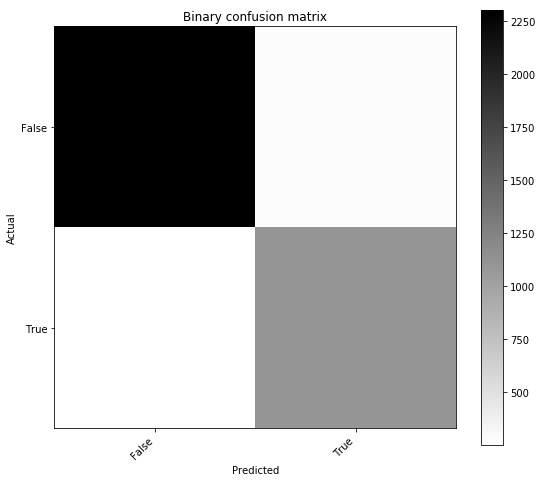

In [188]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [189]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.9352815609847627


In [195]:
# # This is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 4. Calculate Cosine Similary

In [191]:
# df1.head()

In [192]:
# # Calculate out the cosine similarity and see if there's a difference between groups
# def cosine_sim (row):
#     return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

# df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# # Compare cosine sim of correlated and uncorrelated groups
# print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
# print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 5. Save Model

In [202]:
import json
import subprocess

In [206]:
# Save model (in two files, one for weights and one for json)
json_string = model.to_json()
model.save_weights("model1-0.94.h5")
with open('model1-0.94.json', 'w') as outfile:
    json.dump(json_string, outfile)

b'AllVectorResults.lst\nassociations_c.txt\nassociations_d.txt\nCTD_genes.csv.gz.1\nctd-to-vec.ipynb\ndata\ndeleteme.lst\ndiseases.lst\nentities.lst\nfinalclasses.lst\ngeneIDs.txt\nmodel.h5\nmyassociations\nopa2vec.ipynb\nopa-nn-expand-phenotype.ipynb\nopa-nn.ipynb\nuniprotIDs.txt\n'

In [ ]:
with open('model.json', 'w') as outfile:
    json.dump(json.string, outfile)